## DCGAN
- 整體網路架構：

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" alt="dcgan" style="width: 1000px;"/>

#### 程式 12.31 創建資料集

In [730]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "../data/face",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)#去路徑取資料變dataset，不要標籤，因為只需要影像，取圖像後調整圖像大小的大小64*64的圖片，一次取32個，smart_resize會用裁減，避免臉部比例長寬扭曲

Found 3318 files belonging to 1 classes.


#### 程式 12.32 調整像素值範圍

In [731]:
dataset = dataset.map(lambda x: x / 255.)#歸一化(-1~1之間)縮小他們的數值大小差距，且仍保有原始數據的意義，降低單位轉換或是區間對數據的影響

#### 程式 12.33 顯示首張影像

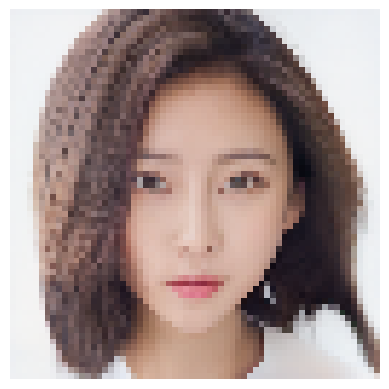

In [732]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")#關閉與軸相關的所有內容
    plt.imshow((x.numpy() * 255).astype("int32")[0])#顯示第一張，numpy()=>將tensor對象轉換為numpy.ndarray對象
    break

### 4 判別器

#### 程式 12.34 GAN辨別器網路

In [733]:
from keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),#圖片為64*64 3是因為RGB

        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),# 64個filter(4*4) 一次滑動兩格 padding(做填補，不希望把圖片邊緣的特徵抹去)
        layers.BatchNormalization(),#批次正規化=>作特徵縮放，(希望數值差距不要太大)，將前一層的Output標準化，防止梯度迷散，過擬合現象
        layers.LeakyReLU(alpha=0.2),#使用LeakyReLU比ReLU多了輸入值小於0時，輸出值=alpha*輸入值，希望可以緩解稀疏性(避免梯度消失的程度)
        
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),#128個filter，通常以倍數成長
        layers.BatchNormalization(),#批次正規化=>作特徵縮放，(希望數值差距不要太大)，將前一層的Output標準化，防止梯度迷散，過擬合現象
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),#批次正規化=>作特徵縮放，(希望數值差距不要太大)，將前一層的Output標準化，防止梯度迷散，過擬合現象
        
        layers.Flatten(),#扁平化(將特徵圖拉為一維向量)
        layers.Dropout(0.5),#放棄一些神經元，避免過度學習
        layers.Dense(1, activation="sigmoid"),#0~1之間
    ],
    name="discriminator",#命名
)

In [734]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_293 (Conv2D)         (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization_321 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_450 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 conv2d_294 (Conv2D)         (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_322 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_451 (LeakyReLU)  (None, 16, 16, 128)    

### 5 生成器

#### 程式GAN生成器網路

In [735]:
latent_dim = 128 #生成器第一個雜訊由128維的向量所組成

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),#生成器輸入雜訊
        layers.Dense(8 * 8 * 256),#全連接層使用判別器扁平層的數量參數，因生成器生成的圖片會要傳入辨別器
        #全連接就是把以前的局部特徵重新通過權值矩陣組裝成完整的圖。因爲用到了所有的局部特徵，所以叫全連接
        layers.Reshape((8, 8, 256)),#轉成3維，自己設數值，但不要太大因為還要反卷積
        
        layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="same"),#反卷積(小特徵變圖片) 寬和高會變大
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),#批次正規化=>作特徵縮放，(希望數值差距不要太大)，將前一層的Output標準化，防止梯度迷散，過擬合現象
        
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),#批次正規化=>作特徵縮放，(希望數值差距不要太大)，將前一層的Output標準化，防止梯度迷散，過擬合現象
        
        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),#批次正規化=>作特徵縮放，(希望數值差距不要太大)，將前一層的Output標準化，防止梯度迷散，過擬合現象
        
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),#最後轉為輸出的shape(64,64,3)
    ],
    name="generator",
)

In [736]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 16384)             2113536   
                                                                 
 reshape_74 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_231 (Conv2  (None, 16, 16, 256)      1638656   
 DTranspose)                                                     
                                                                 
 leaky_re_lu_453 (LeakyReLU)  (None, 16, 16, 256)      0         
                                                                 
 batch_normalization_324 (Ba  (None, 16, 16, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_232 (Conv2  (None, 32, 32, 128)      81

### 5-6 對抗式網路

#### GAN模型

In [737]:
import tensorflow as tf
class GAN(keras.Model):#繼承Keras.Model
    def __init__(self, discriminator, generator, latent_dim):#呼叫class會初始化
        super().__init__()#呼叫父層的初始化
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        #評量指標物件設定
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()#呼叫父層compile()方法
        #設定優化指標物件
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property#只能讀取
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]#傳回評量指標物件

    def train_step(self, real_images):#此function被fit()調用，fit() loops over the dataset and provide each batch to train_step
        batch_size = tf.shape(real_images)[0]#查詢並設定批次的數量 tensor(None, 64, 64, 3)
        #None維度意味著​​它可以是任何標量數，因此您可以使用此模型推斷任意長的輸入。這個維度不影響網絡的大小，它只是表示您可以在測試期間自由選擇輸入的長度（樣本數）
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))#從常態分佈輸出隨機值生成shape為(數量,幾維)的向量
        #print(f"batch_size= {batch_size}")
        generated_images = self.generator(random_latent_vectors)#生成器最後輸出的圖=從上一行取隨機雜訊值去跑生成器序列後產生的圖
        combined_images = tf.concat([generated_images, real_images], axis=0)#將假圖(生成)和真圖進行串接(沿著批次軸(上下))
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],#(多少維(batch_size為一維)全部為一(生成的)和全部為零(真實的)，屬性都是tf.int32)
            axis=0#沿著第一個維度對接(axis=0)
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))#產生一個shape為上行labels維度的隨機數再*0.05(跳脫局部解避免都生成同一張圖片)

        #Train the discriminator
        #計算模型中所有可训练變量的梯度
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)#將結合的圖像(假圖和真圖串接)放進判別器跑模型輸出特徵值
            d_loss = self.loss_fn(labels, predictions)#loss function計算label和predictions特徵值差距
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #從常態分佈輸出隨機值生成shape為(數量,幾維)的向量
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))#生成器標籤希望可以騙過判別器所以給零值

        #Train the generator
        #計算模型中所有可训练變量的梯度
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))#將結合的圖像(假圖)放進判別器跑模型輸出特徵值
            g_loss = self.loss_fn(misleading_labels, predictions)#loss function計算生成器label和predictions特徵值差距
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))#利用優化器改善梯度

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

#### 程式能在訓練過程中，取樣所生成影像的callback物件

In [738]:
import os
import seaborn as sns
import pandas as pd
from collections import Counter
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.loss={}

    def on_train_begin(self,logs):
        self.per_epoch_d_loss=[]
        self.per_epoch_g_loss=[]

    def on_epoch_end(self, epoch, logs=None):
        X,Y=Counter(logs),Counter(self.loss)
        self.loss=dict(X+Y)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        #path="./generate_face"
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")
        self.per_epoch_d_loss.append(logs.get("d_loss"))
        self.per_epoch_g_loss.append(logs.get("g_loss"))

    def on_train_end(self,epoch,logs=None):
        
        plt.clf()
        plt.plot(range(len(self.per_epoch_d_loss)),
        self.per_epoch_d_loss,
        label="Training d_loss for each epoch")

        plt.plot(range(len(self.per_epoch_g_loss)),
        self.per_epoch_g_loss,
        label="Training g_loss for each epoch")

        plt.xlabel(f"epoch{epoch}")
        plt.ylabel("Loss")
        plt.legend()
        self.per_epoch_d_loss=[]

#### 程式編譯並訓練GAN

Epoch 1/3000
104/104 [==============================] - 13s 110ms/step - d_loss: 0.4701 - g_loss: 1.2906
Epoch 2/3000
104/104 [==============================] - 15s 140ms/step - d_loss: 0.5087 - g_loss: 2.4180
Epoch 3/3000
104/104 [==============================] - 14s 131ms/step - d_loss: 0.4345 - g_loss: 2.5146
Epoch 4/3000
104/104 [==============================] - 12s 113ms/step - d_loss: 0.3298 - g_loss: 2.4756
Epoch 5/3000
104/104 [==============================] - 12s 112ms/step - d_loss: 0.6267 - g_loss: 1.8375
Epoch 6/3000
104/104 [==============================] - 12s 111ms/step - d_loss: 0.6483 - g_loss: 0.9991
Epoch 7/3000
104/104 [==============================] - 12s 115ms/step - d_loss: 0.7021 - g_loss: 1.1486
Epoch 8/3000
104/104 [==============================] - 12s 113ms/step - d_loss: 0.6511 - g_loss: 1.0458
Epoch 9/3000
104/104 [==============================] - 12s 110ms/step - d_loss: 0.5941 - g_loss: 0.9666
Epoch 10/3000
104/104 [==============================] 

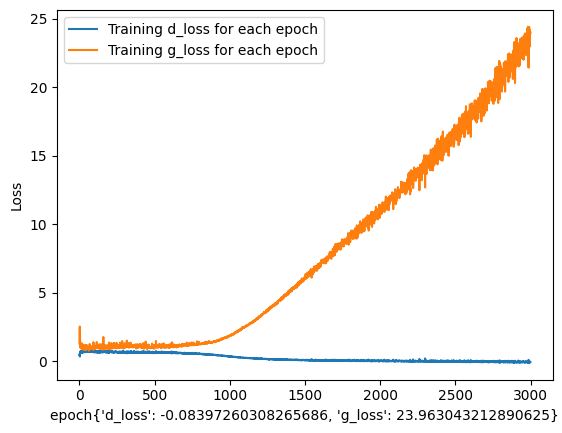

In [739]:
epochs = 3000

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)